In [2]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch

from resalloc.fungible import AllocationProblem
from resalloc.fungible import utilities

from latexify import latexify
latexify()

In [3]:
device = 'cpu'
torch.manual_seed(0)
np.random.seed(0)

USE_DOUBLES = False
SOLVE_WITH_MOSEK = True

def _matching(col, prev_cols):
    return torch.stack([col == pcol for pcol in prev_cols]).any(axis=0)
    
def make_problem(n_jobs, n_resources, device):
    resource_limits = torch.zeros(n_resources, device=device)
    
    scale = n_jobs
    for i in range(n_resources):
        resource_limits[i] = torch.tensor(np.random.uniform(low=0.1, high=1) * scale, device=device).float()
        scale = scale / 1.5

    throughput_matrix = torch.zeros((n_jobs, n_resources), device=device)
    mids = np.linspace(0.3, 1., n_resources)
    prev_cols = [torch.zeros(n_jobs, device=device)]
    for i in range(n_resources):
        col = torch.tensor(np.random.uniform(low=0.1, high=mids[i], size=n_jobs), device=device).float()
        match_at = _matching(col, prev_cols)
        while match_at.any():
            subcol = torch.tensor(np.random.uniform(low=0.1, high=mids[i], size=match_at.sum()), device=device).float()
            col[match_at] = subcol
            match_at = _matching(col, prev_cols)
        throughput_matrix[:, i] = col
        prev_cols.append(col)
    utility_fn = utilities.Log()


    alloc_problem = AllocationProblem(
        throughput_matrix,
        resource_limits=resource_limits,
        utility_function=utility_fn
    )
    return alloc_problem

In [4]:
def make_cp_problem(prob):
    X = cp.Variable(prob.A.shape, nonneg=True)
    A_param = prob.A.cpu().numpy()
    R_param = prob.resource_limits.cpu().numpy()[1:]

    throughput = cp.sum(cp.multiply(A_param, X), axis=1)
    utility = cp.sum(prob.utility_fn.cvxpy_utility(throughput))              

    resource_used = cp.sum(X[:, 1:], axis=0)                             

    problem = cp.Problem(                                                    
        cp.Maximize(utility),                                                
        [                                                                    
            cp.sum(X, axis=1) <= 1,                                          
            resource_used <= R_param
        ],                                                                   
    )                                                                        
    return problem

In [5]:
alloc_problem = make_problem(int(1e6), 4, 'cpu')
print(alloc_problem.resource_limits)
cvxpy_problem = make_cp_problem(alloc_problem)

tensor([        inf, 593932.1250, 495780.2812, 285549.7812, 174931.8125])


In [6]:
def solve_w_mosek(cvxpy_problem, alloc_problem):
    cvxpy_problem.solve(cp.MOSEK,
        mosek_params={
            'MSK_DPAR_INTPNT_CO_TOL_REL_GAP': 1e-3,
            'MSK_DPAR_INTPNT_CO_TOL_DFEAS': 1e-3,
            'MSK_DPAR_INTPNT_CO_TOL_MU_RED': 1e-3, 
            'MSK_DPAR_INTPNT_CO_TOL_PFEAS': 1e-3
        })
    print(cvxpy_problem._solve_time)
    util = alloc_problem.utility(alloc_problem.make_feasible(torch.tensor(cvxpy_problem.variables()[0].value, device=alloc_problem.A.device))) / alloc_problem.n_jobs
    print(util)
    return cvxpy_problem._solve_time, util

def solve_w_ours(alloc_problem, verbose=False):
    _, stats = alloc_problem.solve(max_iter=25, verbose=verbose)
    print(stats.solve_time)
    util = alloc_problem.utility(alloc_problem.make_feasible(alloc_problem.X)) / alloc_problem.n_jobs
    print(alloc_problem.utility(alloc_problem.make_feasible(alloc_problem.X)))
    return stats.solve_time, util

In [34]:
from tqdm.auto import tqdm

def benchmark(jobs_and_resources, n_trials, device, cvxpy=True, verbose=False):
    torch.manual_seed(0)
    np.random.seed(0)
    
    times_ours = []
    times_mosek = []
    utils_ours = []
    utils_mosek = []
    for n_jobs, n_resources in tqdm(jobs_and_resources):
        t_ours = []
        u_ours = []
        t_mosek = []
        u_mosek = []
        for trial_num in tqdm(range(n_trials)):
            alloc_problem = make_problem(n_jobs, n_resources, device)
            cvxpy_problem = make_cp_problem(alloc_problem)
            
            t, u = solve_w_ours(alloc_problem, verbose)
            t_ours.append(t)
            u_ours.append(u)
            if cvxpy:
                print('mosek ...')
                t_m, u_m = solve_w_mosek(cvxpy_problem, alloc_problem)
                t_mosek.append(t_m)
                u_mosek.append(u_m)
                
        times_ours.append(np.array(t_ours))
        times_mosek.append(np.array(t_mosek))
        utils_ours.append(np.array(u_ours))
        utils_mosek.append(np.array(u_mosek))
    return map(np.stack, [times_ours, times_mosek, utils_ours, utils_mosek])

In [32]:
jobs = list(map(int, [1e2, 1e3, 1e4, 1e5, 1e6]))
matrix = [(j, 4) for j in jobs]
jobs_t_ours_cuda, _, jobs_u_ours_cuda, _ = benchmark(matrix, 5, 'cuda', cvxpy=False)
np.save('jobs_t_ours_cuda', jobs_t_ours_cuda)
np.save('jobs_u_ours_cuda', jobs_u_ours_cuda)

0.026294469833374023
-67.16521453857422
0.06179475784301758
-108.19627380371094
0.28142762184143066
-77.16432189941406
0.05835461616516113
-62.92249298095703
0.052037954330444336
-66.55229949951172



0.029804706573486328
-1094.5977783203125
0.08089828491210938
-692.0288696289062
0.06449437141418457
-777.3310546875
0.050781965255737305
-827.531494140625
0.13970565795898438
-658.257080078125



0.06419944763183594
-6365.8798828125
0.05534934997558594
-6924.05078125
0.06140422821044922
-5810.84228515625
0.07205557823181152
-7265.90576171875
0.02714395523071289
-10333.0234375



0.07877540588378906
-81402.609375
0.06814265251159668
-57840.890625
0.038199424743652344
-68289.75
0.05143857002258301
-68087.703125
0.10704445838928223
-81152.578125



0.18192315101623535
-929837.3125
0.08686017990112305
-1227243.0
0.31728529930114746
-630306.125
0.43767642974853516
-615942.25
0.3957633972167969
-614373.8125




In [9]:
jobs_t_ours_cpu, jobs_t_mosek, jobs_u_ours_cpu, jobs_u_mosek = benchmark(matrix, 5, 'cpu', cvxpy=True)
np.save('jobs_t_ours_cpu', jobs_t_ours_cpu)
np.save('jobs_t_mosek', jobs_t_mosek)
np.save('jobs_u_ours_cpu', jobs_u_ours_cpu)
np.save('jobs_u_mosek', jobs_u_mosek)

0.024735212326049805
-65.63729858398438
mosek ...
0.02352285385131836
-0.6571488702809554



0.029909849166870117
-889.2044067382812
mosek ...
0.13083982467651367
-0.889810757166216



0.014200448989868164
-8729.787109375
mosek ...
0.7982940673828125
-0.8745475838503558



0.35524797439575195
-66648.4375
mosek ...
8.936993837356567
-0.6667478226351055



2.320728063583374
-804069.6875
mosek ...
99.82263731956482
-0.8052147153950971




In [10]:
resources = [2, 4, 8, 16]
matrix = [(int(1e6), r) for r in resources]

In [11]:
r_t_ours_cuda, _, r_u_ours_cuda, _ = benchmark(matrix, 5, 'cuda', cvxpy=False)
np.save('r_t_ours_cuda', r_t_ours_cuda)
np.save('r_u_ours_cuda', r_u_ours_cuda)

0.1379237174987793
-914739.75
0.14818215370178223
-836083.0
0.04438662528991699
-1153408.5
0.045903921127319336
-903892.125
0.09153270721435547
-889301.5



0.34292101860046387
-689583.75
0.4866147041320801
-933133.125
0.20057010650634766
-726027.875
0.3704109191894531
-765759.0
0.34874749183654785
-710133.875



2.62369966506958
-1000850.75
2.168287992477417
-921253.875
1.72763991355896
-745855.5
1.7811305522918701
-683389.875
2.408228635787964
-767149.4375



5.425336122512817
-1002813.5
6.503345489501953
-983897.9375
5.83215069770813
-1017954.0
5.552276611328125
-918450.0
6.4934241771698
-958046.125




In [12]:
r_t_ours_cpu, r_t_mosek, r_u_ours_cpu, r_u_mosek = benchmark(matrix, 5, 'cpu', cvxpy=True, verbose=True)
np.save('r_t_ours_cpu', r_t_ours_cpu)
np.save('r_t_mosek', r_t_mosek)
np.save('r_u_ours_cpu', r_u_ours_cpu)
np.save('r_u_mosek', r_u_mosek)

Apr 02 12:11:00 PM: iteration 00 | utility=-1.29645 | dual_value=-0.82161 | gap=4.75e-01
Apr 02 12:11:01 PM: iteration 02 | utility=-0.914739 | dual_value=-0.909601 | gap=5.14e-03
Apr 02 12:11:02 PM: Converged in 004 iterations, with residual 0.000434625
2.0138776302337646
-914739.375
mosek ...
61.785062074661255
-0.9159820590839896



Apr 02 12:12:11 PM: iteration 00 | utility=-1.1723 | dual_value=-0.140479 | gap=1.03e+00
Apr 02 12:12:12 PM: iteration 02 | utility=-1.03939 | dual_value=-0.704796 | gap=3.35e-01
Apr 02 12:12:12 PM: iteration 04 | utility=-0.868286 | dual_value=-0.789845 | gap=7.84e-02
Apr 02 12:12:13 PM: iteration 06 | utility=-0.815193 | dual_value=-0.808998 | gap=6.20e-03
Apr 02 12:12:16 PM: iteration 08 | utility=-0.822201 | dual_value=-0.809513 | gap=1.27e-02
Apr 02 12:12:17 PM: iteration 10 | utility=-0.810638 | dual_value=-0.809653 | gap=9.85e-04
Apr 02 12:12:17 PM: Converged in 011 iterations, with residual 0.000984688
5.911263704299927
-810638.125
mosek ...
114.9179847240448
-0.8105337724084113



Apr 02 12:14:24 PM: iteration 00 | utility=-0.958098 | dual_value=0.133095 | gap=1.09e+00
Apr 02 12:14:25 PM: iteration 02 | utility=-1.12439 | dual_value=-0.490686 | gap=6.34e-01
Apr 02 12:14:26 PM: iteration 04 | utility=-0.885663 | dual_value=-0.627245 | gap=2.58e-01
Apr 02 12:14:27 PM: iteration 06 | utility=-0.792078 | dual_value=-0.651205 | gap=1.41e-01
Apr 02 12:14:29 PM: iteration 08 | utility=-0.771059 | dual_value=-0.670191 | gap=1.01e-01
Apr 02 12:14:34 PM: iteration 10 | utility=-0.72455 | dual_value=-0.677928 | gap=4.66e-02
Apr 02 12:14:37 PM: iteration 12 | utility=-0.691061 | dual_value=-0.67831 | gap=1.28e-02
Apr 02 12:14:38 PM: iteration 14 | utility=-0.683418 | dual_value=-0.678462 | gap=4.96e-03
Apr 02 12:14:40 PM: iteration 16 | utility=-0.682028 | dual_value=-0.67851 | gap=3.52e-03
Apr 02 12:14:41 PM: Converged in 018 iterations, with residual 0.000531062
17.476947784423828
-679045.8125
mosek ...
132.77996802330017
-0.6798614919849667



Apr 02 12:17:18 PM: iteration 00 | utility=-1.4206 | dual_value=-0.599227 | gap=8.21e-01
Apr 02 12:17:21 PM: iteration 02 | utility=-1.17133 | dual_value=-0.828911 | gap=3.42e-01
Apr 02 12:17:26 PM: iteration 04 | utility=-1.08996 | dual_value=-0.930835 | gap=1.59e-01
Apr 02 12:17:31 PM: iteration 06 | utility=-1.07436 | dual_value=-0.938911 | gap=1.35e-01
Apr 02 12:17:34 PM: iteration 08 | utility=-1.06021 | dual_value=-0.944072 | gap=1.16e-01
Apr 02 12:17:37 PM: iteration 10 | utility=-1.01635 | dual_value=-0.949811 | gap=6.65e-02
Apr 02 12:17:40 PM: iteration 12 | utility=-1.01972 | dual_value=-0.953545 | gap=6.62e-02
Apr 02 12:17:46 PM: iteration 14 | utility=-0.999619 | dual_value=-0.954919 | gap=4.47e-02
Apr 02 12:17:51 PM: iteration 16 | utility=-0.992257 | dual_value=-0.955568 | gap=3.67e-02
Apr 02 12:17:56 PM: iteration 18 | utility=-0.994614 | dual_value=-0.955601 | gap=3.90e-02
Apr 02 12:18:01 PM: iteration 20 | utility=-0.996736 | dual_value=-0.955618 | gap=4.11e-02
Apr 02 

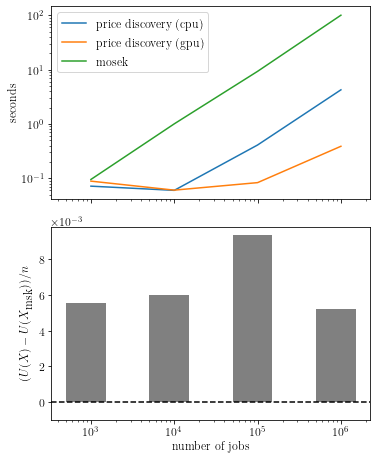

In [76]:
import latexify
latexify.latexify()
import matplotlib.pyplot as plt

jobs_t_ours_cuda = np.load('jobs_t_ours_cuda.npy')
jobs_u_ours_cuda = np.load('jobs_u_ours_cuda.npy')

jobs_t_ours_cpu = np.load('jobs_t_ours_cpu.npy')
jobs_t_mosek = np.load('jobs_t_mosek.npy')
jobs_u_ours_cpu = np.load('jobs_u_ours_cpu.npy')
jobs_u_mosek = np.load('jobs_u_mosek.npy')

fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((5.4, 7.2/1.1))

axs[0].plot(jobs, jobs_t_ours_cpu.mean(axis=1), label='price discovery (cpu)')
axs[0].plot(jobs, jobs_t_ours_cuda.mean(axis=1), label='price discovery (gpu)')
axs[0].plot(jobs, jobs_t_mosek.mean(axis=1), label='mosek')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel('seconds')
axs[0].legend()


axs[1].bar(jobs,
           jobs_u_ours_cpu.mean(axis=1) - jobs_u_mosek.mean(axis=1),
           width=np.array([10, 100, 1000, 10000])*100, color='gray')
#axs[1].plot(jobs, jobs_u_ours_cpu.mean(axis=1) - jobs_u_mosek.mean(axis=1))
axs[1].axhline(0, linestyle='--', color='k')
axs[1].set_ylim(bottom=-0.001)
axs[1].set_xscale('log')
axs[1].set_ylabel('$(U(X) - U(X_{\\textnormal{msk}}))/n$')
axs[1].set_xlabel('number of jobs')
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('v_mosek_jobs.pdf')

In [ ]:
import latexify
latexify.latexify()
import matplotlib.pyplot as plt


jobs_t_ours_cpu = np.load('jobs_t_ours_cpu.npy')
jobs_t_mosek = np.load('jobs_t_mosek.npy')
jobs_u_ours_cpu = np.load('jobs_u_ours_cpu.npy')
jobs_u_mosek = np.load('jobs_u_mosek.npy')

fig, axs = plt.subplots(2, 1)
fig.set_size_inches((5.4, 7.2/1.1))

axs[0].plot(jobs, jobs_t_ours_cpu.mean(axis=1), label='price discovery (cpu)')
axs[0].plot(jobs, jobs_t_ours_cuda.mean(axis=1), label='price discovery (gpu)')
axs[0].plot(jobs, jobs_t_mosek.mean(axis=1), label='mosek')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel('seconds')
axs[0].legend()
#plt.show()


plt.tight_layout()
plt.savefig('v_mosek_jobs.pdf')

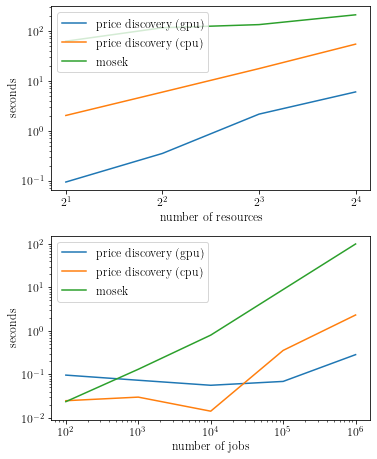

In [33]:
import latexify
latexify.latexify()
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 1)
fig.set_size_inches((5.4, 7.2/1.1))

axs[0].plot(resources, r_t_ours_cuda.mean(axis=1), label='price discovery (gpu)')
axs[0].plot(resources, r_t_ours_cpu.mean(axis=1), label='price discovery (cpu)')
axs[0].plot(resources, r_t_mosek.mean(axis=1), label='mosek')
axs[0].set_xscale('log', basex=2)
axs[0].set_yscale('log')
axs[0].set_ylabel('seconds')
axs[0].legend(loc='upper left')
axs[0].set_xlabel('number of resources')

#plt.show()


jobs = list(map(int, [1e2, 1e3, 1e4, 1e5, 1e6]))
axs[1].plot(jobs, jobs_t_ours_cuda.mean(axis=1), label='price discovery (gpu)')
axs[1].plot(jobs, jobs_t_ours_cpu.mean(axis=1), label='price discovery (cpu)')
axs[1].plot(jobs, jobs_t_mosek.mean(axis=1), label='mosek')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel('seconds')
axs[1].legend()
axs[1].set_xlabel('number of jobs')

plt.tight_layout()
plt.savefig('v_mosek.pdf')